In [1]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import NN_evaluation
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Import the original data for plotting
sc = "sc01"
period = "2030"
folder = "../Data/3-bus_DC_fy/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
len(all_executions)
executions = all_executions[0:40]
te_s = 0.3
val_s = 0.3
outp = "SystemCosts"

In [3]:
#Analyze the loss results
df_losses = pd.read_csv("Loss_results_csv/test_rand_hours_3-bus_DC_0.3_v0.3_PF_0_20.csv",index_col = 0)
df_losses.columns

Index(['Model_type', 'Dor', 'Relu_out', 'Batch_size', 'Lr', 'Epochs',
       'Min_val', 'Nb_hours_used', 'Tr_l', 'Te_l', 'V_l', 'Tr_l_mse',
       'Te_l_mse', 'V_l_mse', 'Tr_l_mae', 'Te_l_mae', 'V_l_mae', 'fy_l',
       'fy_l_mse', 'fy_l_mae', 'Train_time', 'Eval_time', 'alpha', 'beta',
       'MAE', 'Test size', 'Val size'],
      dtype='object')

In [19]:
df_losses.sort_values(by="fy_l")

,Model_type,Dor,Relu_out,Batch_size,Lr,Epochs,Min_val,Nb_hours_used,Tr_l,Te_l,...,fy_l,fy_l_mse,fy_l_mae,Train_time,Eval_time,alpha,beta,MAE,Test size,Val size
154,"(1, 1)",0,False,64,0.0025,128,min_val,3900,1.539246e-07,1.553373e-07,...,1.545630e-07,1.545630e-07,0.000285,122.851247,0.009102,0,1,False,0.3,0.3
120,"(1, 1)",0,False,64,0.0025,64,min_val,3100,1.506745e-07,1.540058e-07,...,1.802297e-07,1.802297e-07,0.000313,48.951622,0.007308,0,1,False,0.3,0.3
121,"(1, 1)",0,False,64,0.0025,64,all_epochs,3100,1.551955e-07,1.587300e-07,...,1.860798e-07,1.860798e-07,0.000317,48.951622,0.006828,0,1,False,0.3,0.3
155,"(1, 1)",0,False,64,0.0025,128,all_epochs,3900,2.144784e-07,2.178000e-07,...,2.157418e-07,2.157418e-07,0.000375,122.851247,0.007914,0,1,False,0.3,0.3
130,"(1, 1)",0,False,64,0.0025,128,min_val,3300,2.344408e-07,2.368703e-07,...,2.467634e-07,2.467634e-07,0.000441,103.811794,0.007015,0,1,False,0.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,"(1, 1)",0,False,64,0.0025,128,all_epochs,700,3.851713e-05,3.823418e-05,...,3.809115e-05,3.809115e-05,0.004602,22.852075,0.004937,0,1,False,0.3,0.3
117,"(1, 1)",0,False,128,0.0025,64,all_epochs,2900,4.053659e-05,3.956786e-05,...,4.075122e-05,4.075122e-05,0.005543,32.625400,0.006966,0,1,False,0.3,0.3
69,"(1, 1)",0,False,128,0.0025,64,all_epochs,1700,4.226550e-05,4.226684e-05,...,4.113584e-05,4.113584e-05,0.005587,19.705774,0.007109,0,1,False,0.3,0.3
13,"(1, 1)",0,False,128,0.0025,64,all_epochs,300,3.719917e-05,4.367595e-05,...,4.219734e-05,4.219734e-05,0.005389,3.558381,0.003515,0,1,False,0.3,0.3


<Axes: xlabel='Nb_hours_used', ylabel='fy_l'>

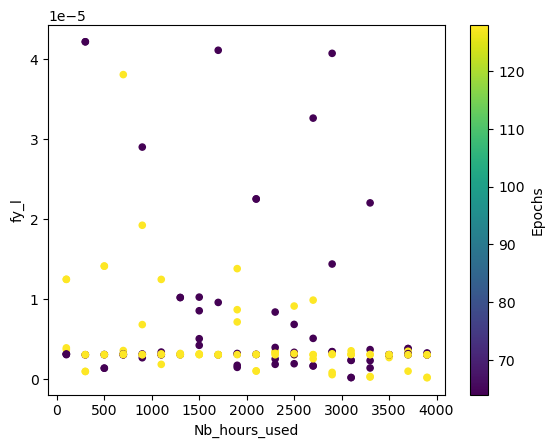

In [29]:
df_losses.plot.scatter(x="Nb_hours_used",y="fy_l",c = "Epochs",colormap = "viridis")

<Axes: xlabel='Te_l', ylabel='fy_l'>

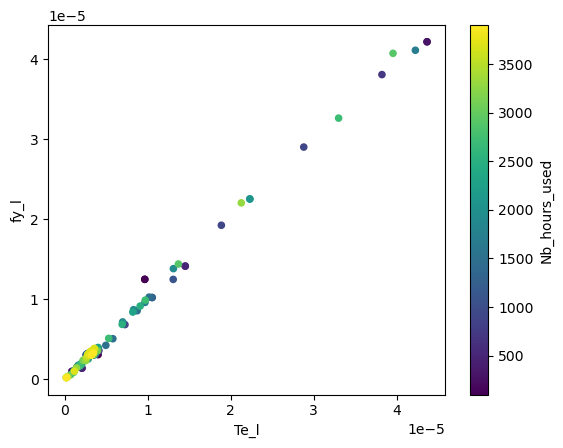

In [28]:
df_losses.plot.scatter(x="Te_l",y="fy_l",c = "Nb_hours_used",colormap = "viridis")

In [3]:
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"])
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

input_f_sc01_Network_Existing_Generation_Full_2030.csv
14
input_f_sc01_Network_Full_Generation_Full_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_No

In [8]:
hyperloop_name = "test_rand_hours_3-bus_DC_0.3_v0.3_PF_0_20"
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)

f = df_losses.alpha ==0.0

loss_to_sort = "Te_l_mse"

[8, 3, 2]


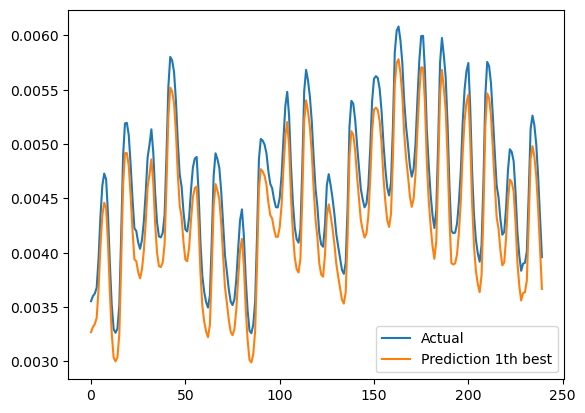

In [41]:
#Visualisation of multiple models in input order
ex = all_executions[1]


#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()


s = 24*0
e=s+24*10
plt.plot(ex_out[s:e],label = "Actual")

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

Network_Existing_Generation_Full
[8, 3, 2]
Network_Full_Generation_Full
[8, 3, 2]


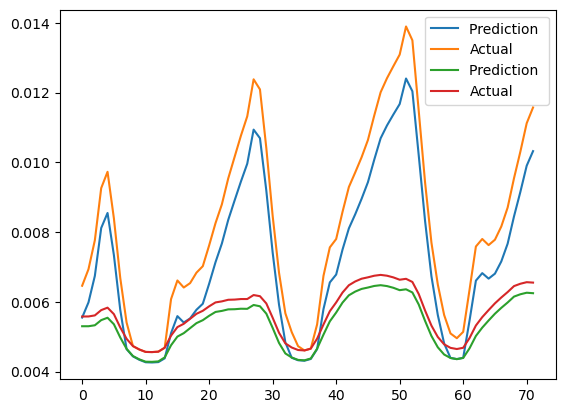

In [53]:
#Visualisation of multiple executions in input order

#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])

j = 2

s = 4600
e=s+72


for ex_i in [0,1]:
    ex = all_executions[ex_i]
    print(ex)
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    ex_out = dfs_out[ex].sum(axis=1).to_numpy()
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction ")
    plt.plot(ex_out[s:e],label = f"Actual")

plt.legend()

[8, 3, 2]


Text(0.5, 1.0, 'Derived line benefits')

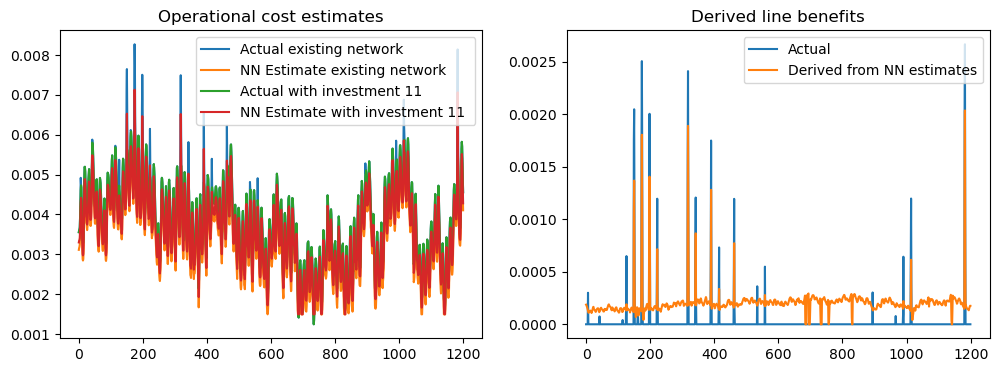

In [66]:
#Visualisation of multiple executions in input order
f = df_losses.alpha ==0.0
loss_to_sort = "Te_l_mae"
xth_best = 1
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)

#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])

l_idx = 11
ex = all_executions[l_idx]
negf = all_executions[0]


ex_in_e = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_in_negf = torch.nan_to_num(dfs_in[negf].to_numpy()/maxs["in"])

prediction_e = m(ex_in_e.float())[0].detach().numpy()
prediction_negf = m(ex_in_negf.float())[0].detach().numpy()

actual_e = NN_evaluation.get_actual_from_dfs_out(ex,dfs_out)
actual_negf = NN_evaluation.get_actual_from_dfs_out(negf,dfs_out)

lb_est = prediction_negf- prediction_e
lb_actual = NN_evaluation.calculate_lb_from_dfs_out(dfs_out,ex)



#s= random.randint(0,len(actual_e))
s=0
e = s+24*50

fig, axs = plt.subplots(1,2,figsize = (12,4))

axs[0].plot(actual_negf[s:e],label = "Actual existing network")
axs[0].plot(prediction_e[s:e],label = "NN Estimate existing network")
axs[0].plot(actual_e[s:e],label = f"Actual with investment {l_idx}")
axs[0].plot(prediction_negf[s:e],label = f"NN Estimate with investment {l_idx} ")

axs[0].legend()
axs[0].set_title("Operational cost estimates")


axs[1].plot(lb_actual[s:e],label = "Actual")
axs[1].plot(lb_est[s:e],label = "Derived from NN estimates")

axs[1].legend()
axs[1].set_title(f"Derived line benefits")

#axs[2].hist(lb_actual/actual_negf,bins= 100)


In [11]:
row

,Model_type,Dor,Relu_out,Batch_size,Lr,Epochs,Min_val,Nb_hours_used,Tr_l,Te_l,...,fy_l,fy_l_mse,fy_l_mae,Train_time,Eval_time,alpha,beta,MAE,Test size,Val size
120,"(1, 1)",0,False,64,0.0025,64,min_val,3100,1.506745e-07,1.540058e-07,...,1.802297e-07,1.802297e-07,0.000313,48.951622,0.007308,0,1,False,0.3,0.3


In [34]:
#Check loss calculation 

manual_diff = prediction.flatten() - ex_out

In [39]:
(manual_diff**2)

(8736,)

In [30]:
ex_out.shape

(8736,)